In [43]:
# 데이터 시각화에 사용할 라이브러리
import matplotlib.pyplot as plt
import seaborn as sns

plt.ion() #주피터에서 그래프 프린트하게 해주는 변수

In [44]:
import easydict
import json
args = easydict.EasyDict()

# path 정보
args.default_path = 'data/'  # 데이터 파일
args.train_csv = args.default_path+'hotel_bookings.csv'

# 데이터 분석을 위한 변수들
args.random_state = 42
args.results = []
# with open(args.save_results, 'r') as file:
#     args.results = json.load(file)

args.results

[]

# 1단계: 데이터 로드 및 기본 정보 확인
print("=== 호텔 예약 데이터 로드 ===")

# 데이터 로드
try:
    df = pd.read_csv(args.train_csv)

    # 타겟 변수 확인
    if 'is_canceled' in df.columns:
        print(f"\n=== 타겟 변수 분포 ===")
        target_dist = df['is_canceled'].value_counts()
        print(f"예약 유지: {target_dist[0]:,}건 ({target_dist[0]/len(df)*100:.1f}%)")
        print(f"예약 취소: {target_dist[1]:,}건 ({target_dist[1]/len(df)*100:.1f}%)")
    


In [45]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('fivethirtyeight')
plt.ion()

import warnings
warnings.filterwarnings('ignore')

In [46]:
df = pd.read_csv(args.train_csv)

# 2.기본 DEA
- 전체 데이터 특성 파악

In [47]:
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

In [49]:
# 결측치가 있는 컬럼과 그 결측치의 비율
missing_summary = df.isnull().sum()
missing_summary = missing_summary[missing_summary > 0]
missing_percent = (missing_summary / len(df))
missing_summary, missing_percent

(children         4
 country        488
 agent        16340
 company     112593
 dtype: int64,
 children    0.000034
 country     0.004087
 agent       0.136862
 company     0.943069
 dtype: float64)

Text(0.5, 1.0, '수치형 변수 상관관계 히트맵')

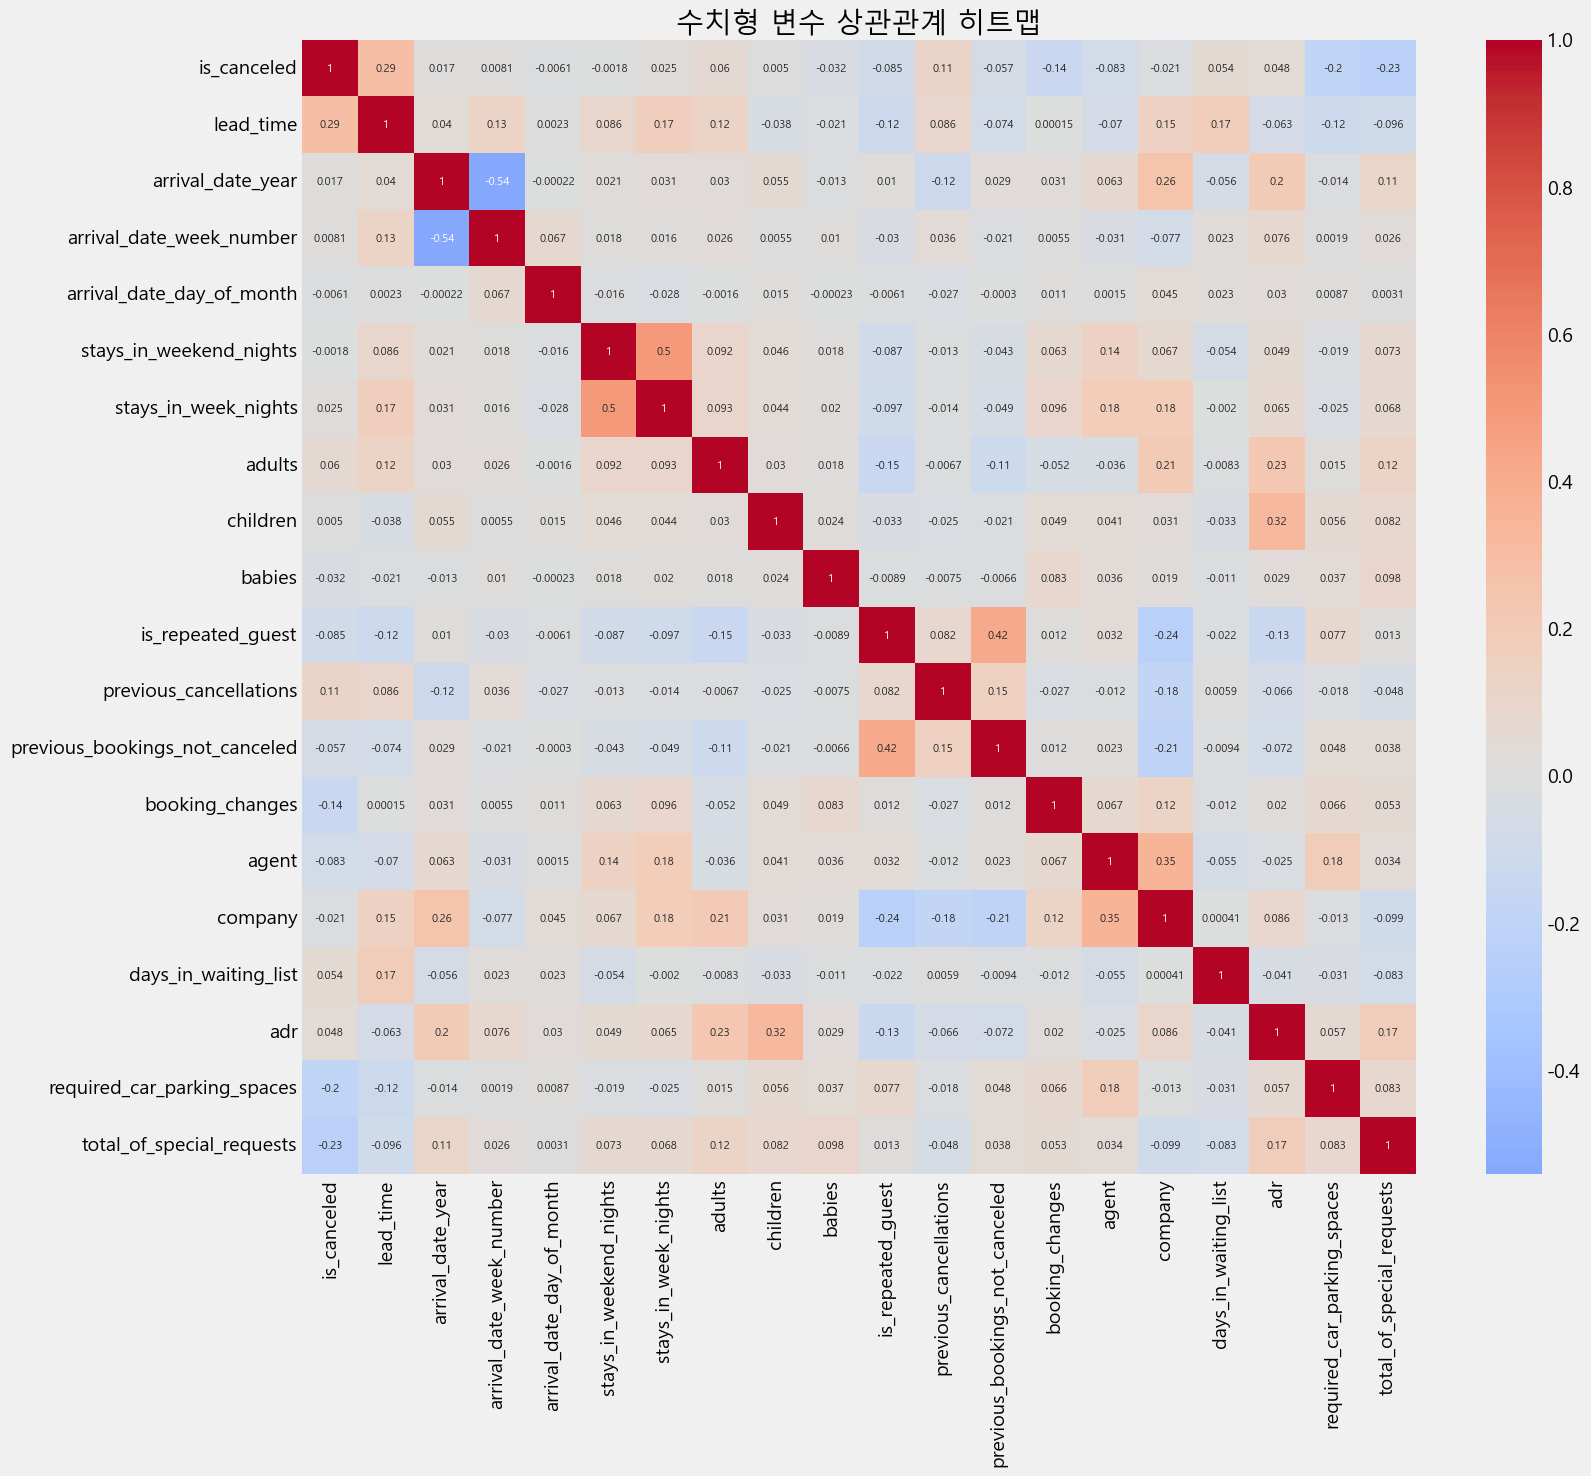

In [50]:
# 수치형 변수만 선택해서 상관계수
numeric_cols = df.select_dtypes(include=[np.number]).columns
plt.figure(figsize=(16, 14))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm', center=0, annot_kws={'size': 8})
plt.title('수치형 변수 상관관계 히트맵')

In [51]:
# 상관계수 매트릭스
corr_matrix = df[numeric_cols].corr()

# stack으로 펼치기
corr_pairs = corr_matrix.stack()

# 자기 자신과의 상관계수(1.0) 제거 및 중복 제거
corr_pairs = corr_pairs[corr_pairs.index.get_level_values(0) < corr_pairs.index.get_level_values(1)]

# 0.02 이상인 것만 필터링
high_corr_pairs = corr_pairs[abs(corr_pairs) >= 0.02]

# DataFrame으로 변환하고 절댓값 컬럼 추가
high_corr_df = high_corr_pairs.reset_index()
high_corr_df.columns = ['Variable_1', 'Variable_2', 'Correlation']
high_corr_df['Abs_Correlation'] = abs(high_corr_df['Correlation'])

# 절댓값 기준으로 내림차순 정렬
high_corr_df = high_corr_df.sort_values('Abs_Correlation', ascending=False)

print("상관계수 0.02 이상인 변수 쌍 (절댓값 큰 순서):")
print(high_corr_df)

상관계수 0.02 이상인 변수 쌍 (절댓값 큰 순서):
                   Variable_1                      Variable_2  Correlation  \
24   arrival_date_week_number               arrival_date_year    -0.540561   
37       stays_in_week_nights         stays_in_weekend_nights     0.498969   
73          is_repeated_guest  previous_bookings_not_canceled     0.418056   
100                     agent                         company     0.350746   
126                       adr                        children     0.324854   
..                        ...                             ...          ...   
57                   children  previous_bookings_not_canceled    -0.021072   
63                     babies                       lead_time    -0.020915   
27   arrival_date_week_number  previous_bookings_not_canceled    -0.020904   
104                   company                     is_canceled    -0.020642   
64                     babies            stays_in_week_nights     0.020191   

     Abs_Correlation  
24       

Text(0.5, 1.0, '상관계수 0.02 이상만 표시한 히트맵')

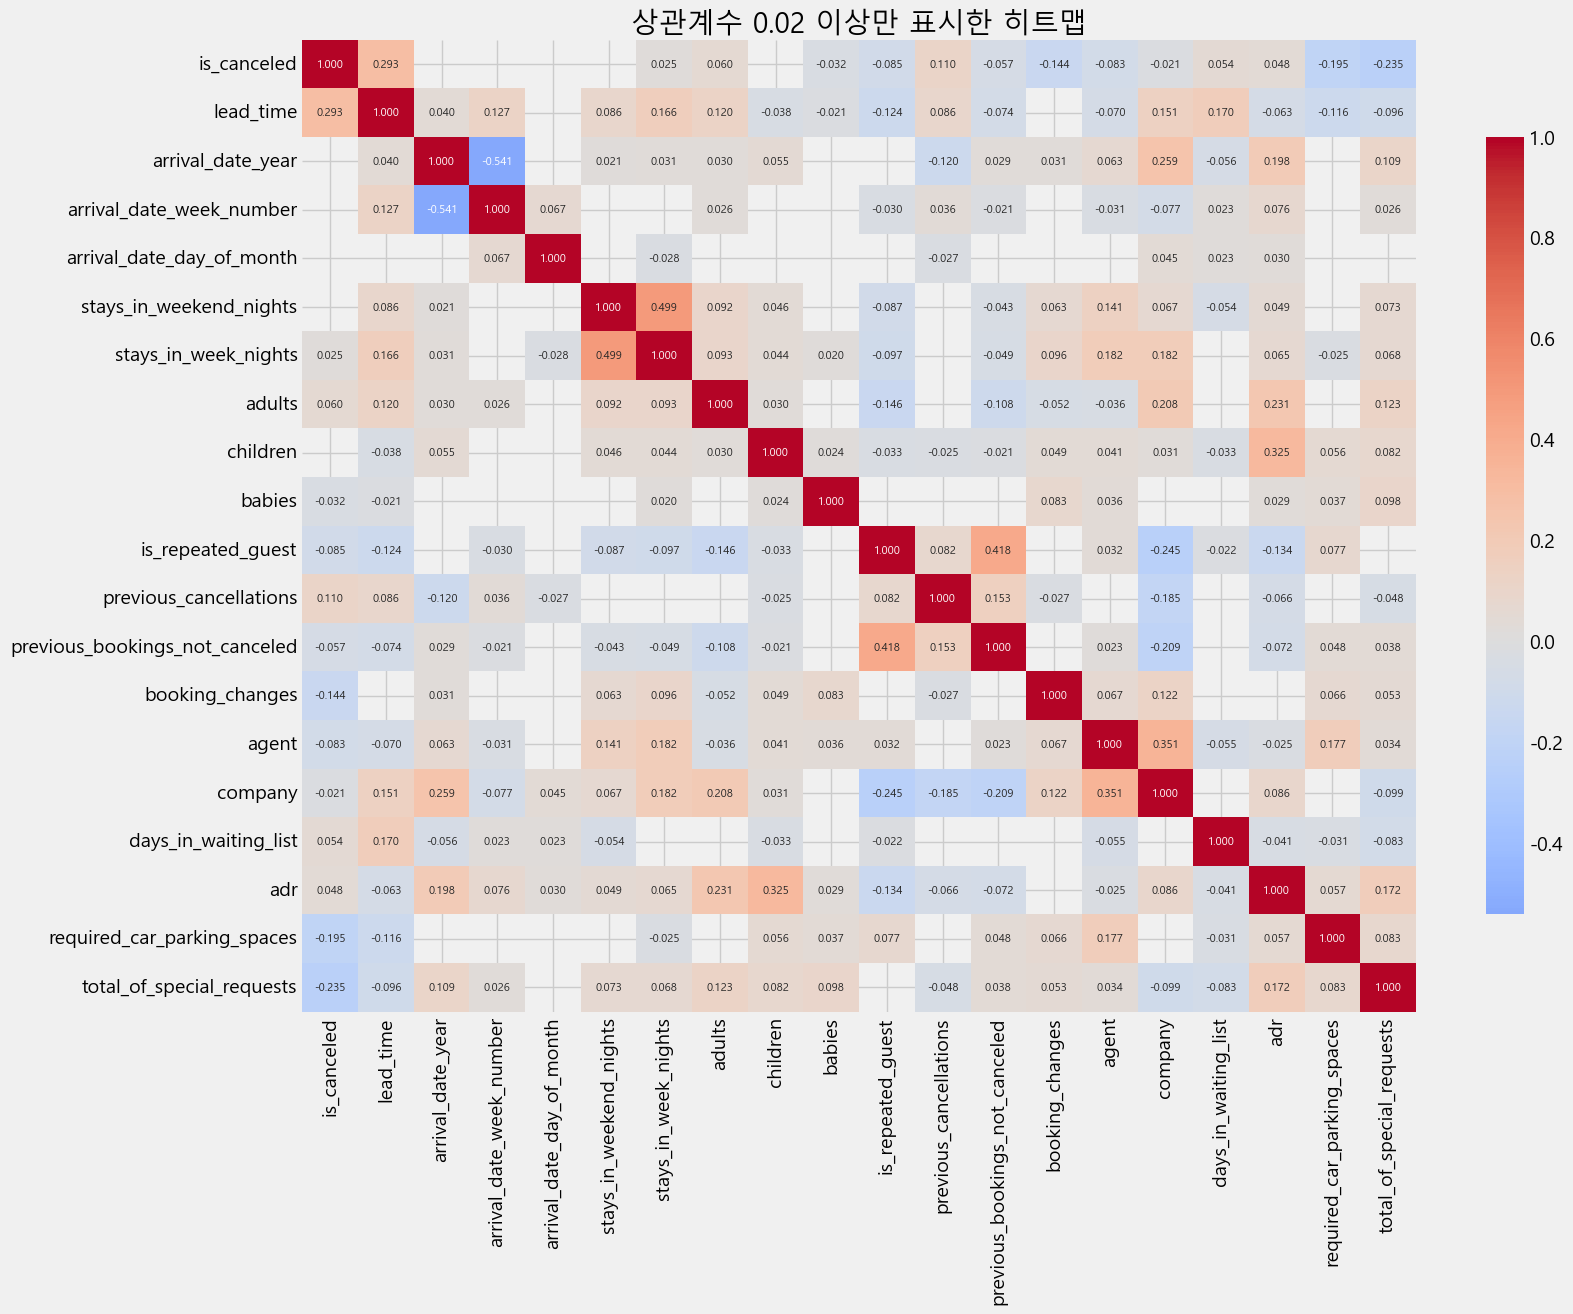

In [52]:
# 0.02 이상인 것만 표시하는 마스크
corr_matrix = df[numeric_cols].corr()
mask = abs(corr_matrix) < 0.02

plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, 
            mask=mask,  # 0.02 미만은 회색으로
            annot=True, 
            cmap='coolwarm', 
            center=0,
            fmt='.3f',
            annot_kws={'size': 8},
            cbar_kws={'shrink': .8})
plt.title('상관계수 0.02 이상만 표시한 히트맵')

In [53]:
# data폴더에 저장 (폴더가 없으면 생성)
import os
os.makedirs('results', exist_ok=True)

high_corr_df.to_csv('data/high_correlation_pairs.csv', 
                    index=False,
                    encoding='utf-8-sig')
print("CSV 파일이 저장되었습니다: data/high_correlation_pairs.csv")

CSV 파일이 저장되었습니다: data/high_correlation_pairs.csv


In [54]:
df[numeric_cols].head(10)

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
0,0,342,2015,27,1,0,0,2,0.0,0,0,0,0,3,NaN,NaN,0,0.0,0,0
1,0,737,2015,27,1,0,0,2,0.0,0,0,0,0,4,NaN,NaN,0,0.0,0,0
2,0,7,2015,27,1,0,1,1,0.0,0,0,0,0,0,NaN,NaN,0,75.0,0,0
3,0,13,2015,27,1,0,1,1,0.0,0,0,0,0,0,304.0,NaN,0,75.0,0,0
4,0,14,2015,27,1,0,2,2,0.0,0,0,0,0,0,240.0,NaN,0,98.0,0,1
5,0,14,2015,27,1,0,2,2,0.0,0,0,0,0,0,240.0,NaN,0,98.0,0,1
6,0,0,2015,27,1,0,2,2,0.0,0,0,0,0,0,NaN,NaN,0,107.0,0,0
7,0,9,2015,27,1,0,2,2,0.0,0,0,0,0,0,303.0,NaN,0,103.0,0,1
8,1,85,2015,27,1,0,3,2,0.0,0,0,0,0,0,240.0,NaN,0,82.0,0,1
9,1,75,2015,27,1,0,3,2,0.0,0,0,0,0,0,15.0,NaN,0,105.5,0,0


In [55]:
# 중복 행 수 - 11만개의 데이터 중 중복
df.duplicated().sum()

np.int64(31994)

In [56]:
# 목표변수 - 결측치 없음
df['is_canceled'].isnull().sum()

np.int64(0)

In [57]:
# 목표 변수 _ 분포 - 37퍼센트 확률로 캔슬됨. 데이터 불균형 문제 존재.
df['is_canceled'].value_counts()/len(df)

is_canceled
0    0.629584
1    0.370416
Name: count, dtype: float64

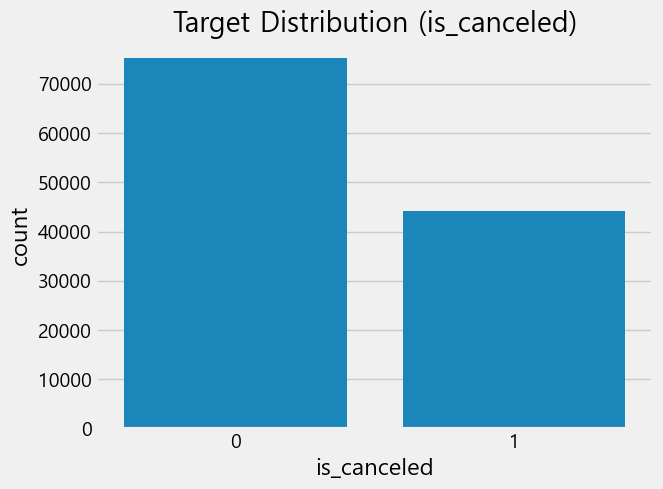

In [58]:
sns.countplot(data=df, x='is_canceled')
plt.title("Target Distribution (is_canceled)")
plt.show()

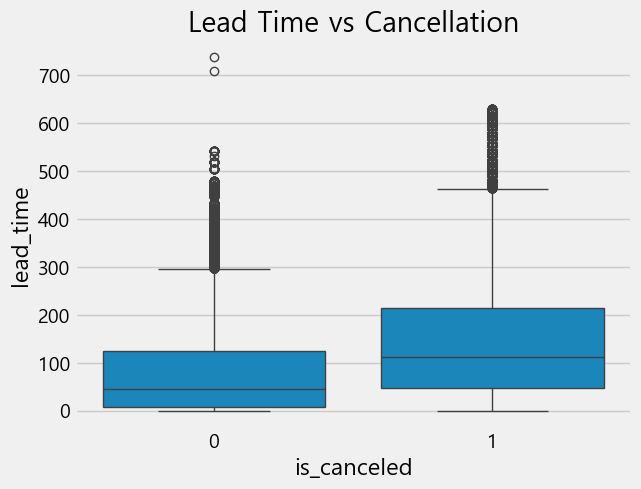

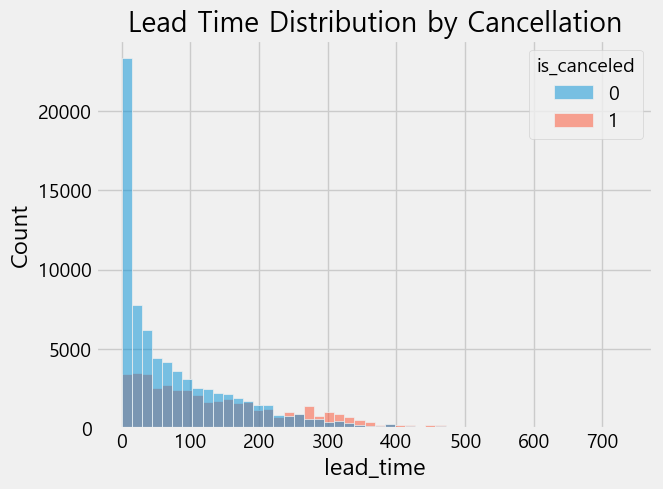

In [59]:
sns.boxplot(data=df, x='is_canceled', y='lead_time')
plt.title("Lead Time vs Cancellation")
plt.show()
# 리드타임의 700일 이상인 이상치 제거 필요

sns.histplot(data=df, x='lead_time', hue='is_canceled', bins=50, kde=False)
plt.title("Lead Time Distribution by Cancellation")
plt.show()

In [60]:
# 범주형 컬럼의 비율
import numpy as np
# 모든 수치형 제외
categorical_cols = df.select_dtypes(exclude=[np.number]).columns.tolist()

# 컬럼명과 유니크 개수만
print("=== 범주형 변수 유니크 개수 ===")
def print_categorical_cols():
    for col in categorical_cols:
        print(f"{col}, {df[col].dtype} : {df[col].unique()}")

print_categorical_cols()

=== 범주형 변수 유니크 개수 ===
hotel, object : ['Resort Hotel' 'City Hotel']
arrival_date_month, object : ['July' 'August' 'September' 'October' 'November' 'December' 'January'
 'February' 'March' 'April' 'May' 'June']
meal, object : ['BB' 'FB' 'HB' 'SC' 'Undefined']
country, object : ['PRT' 'GBR' 'USA' 'ESP' 'IRL' 'FRA' nan 'ROU' 'NOR' 'OMN' 'ARG' 'POL'
 'DEU' 'BEL' 'CHE' 'CN' 'GRC' 'ITA' 'NLD' 'DNK' 'RUS' 'SWE' 'AUS' 'EST'
 'CZE' 'BRA' 'FIN' 'MOZ' 'BWA' 'LUX' 'SVN' 'ALB' 'IND' 'CHN' 'MEX' 'MAR'
 'UKR' 'SMR' 'LVA' 'PRI' 'SRB' 'CHL' 'AUT' 'BLR' 'LTU' 'TUR' 'ZAF' 'AGO'
 'ISR' 'CYM' 'ZMB' 'CPV' 'ZWE' 'DZA' 'KOR' 'CRI' 'HUN' 'ARE' 'TUN' 'JAM'
 'HRV' 'HKG' 'IRN' 'GEO' 'AND' 'GIB' 'URY' 'JEY' 'CAF' 'CYP' 'COL' 'GGY'
 'KWT' 'NGA' 'MDV' 'VEN' 'SVK' 'FJI' 'KAZ' 'PAK' 'IDN' 'LBN' 'PHL' 'SEN'
 'SYC' 'AZE' 'BHR' 'NZL' 'THA' 'DOM' 'MKD' 'MYS' 'ARM' 'JPN' 'LKA' 'CUB'
 'CMR' 'BIH' 'MUS' 'COM' 'SUR' 'UGA' 'BGR' 'CIV' 'JOR' 'SYR' 'SGP' 'BDI'
 'SAU' 'VNM' 'PLW' 'QAT' 'EGY' 'PER' 'MLT' 'MWI' 'ECU' 'MDG' 'ISL' 'U

In [61]:
# 노트북 맨 위에 이 코드 추가
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Malgun Gothic'  # Windows
plt.rcParams['axes.unicode_minus'] = False

print("한글 폰트 설정 완료! 이제 한글이 정상 표시됩니다.")

한글 폰트 설정 완료! 이제 한글이 정상 표시됩니다.


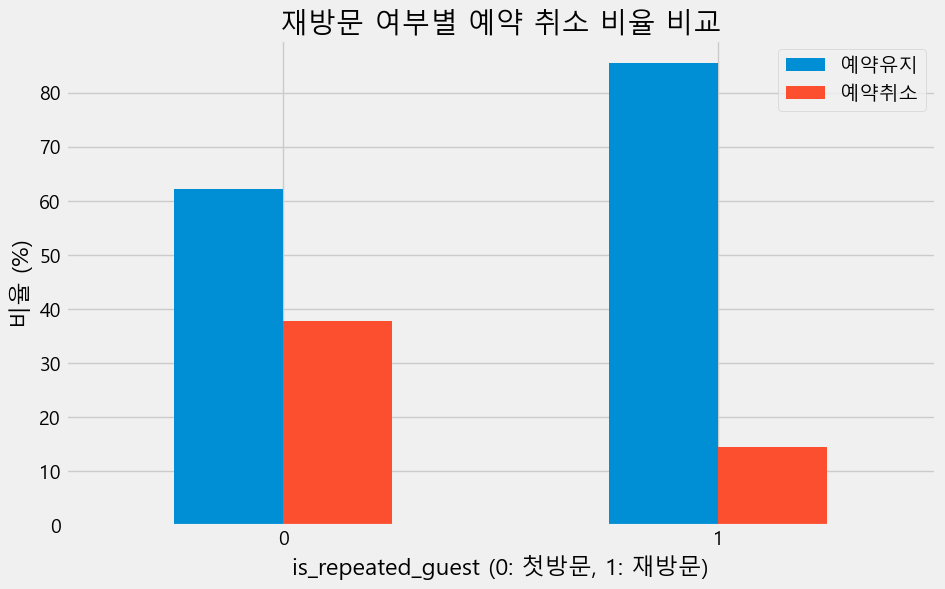

재방문 여부별 취소 비율:
is_canceled                0          1
is_repeated_guest                      
0                  62.214916  37.785084
1                  85.511811  14.488189


In [62]:
# 교차표 생성 후 비율 계산
cross_tab = pd.crosstab(df['is_repeated_guest'], df['is_canceled'], normalize='index') * 100

# 비율 막대그래프
cross_tab.plot(kind='bar', stacked=False, figsize=(10, 6))
plt.title('재방문 여부별 예약 취소 비율 비교')
plt.xlabel('is_repeated_guest (0: 첫방문, 1: 재방문)')
plt.ylabel('비율 (%)')
plt.legend(['예약유지', '예약취소'])
plt.xticks(rotation=0)
plt.show()

# 수치로도 확인
print("재방문 여부별 취소 비율:")
print(cross_tab)

## 재방문한 고객일수록 취소율이 낮다

🎯 Target 분포:
is_canceled
0    0.629584
1    0.370416
Name: proportion, dtype: float64


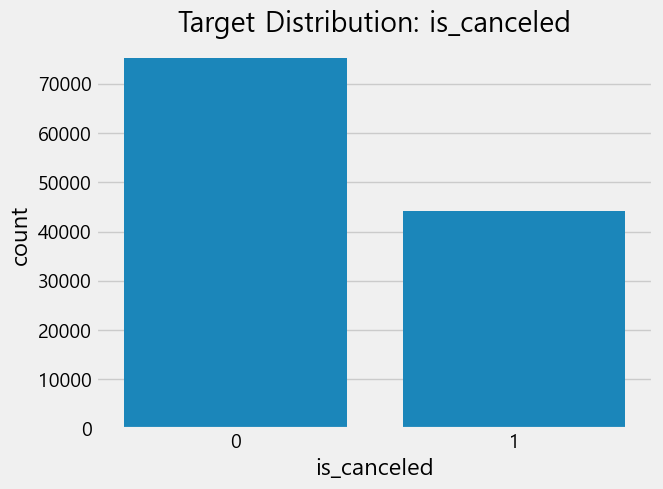


📌 hotel 분포:
hotel
City Hotel      0.664461
Resort Hotel    0.335539
Name: proportion, dtype: float64


<Figure size 1200x600 with 0 Axes>

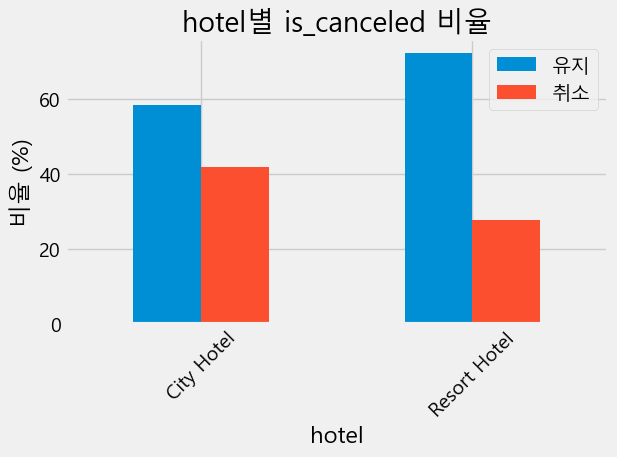

hotel별 취소/유지 비율:
is_canceled      0     1
hotel                   
City Hotel    58.3  41.7
Resort Hotel  72.2  27.8

📌 arrival_date_month 분포:
arrival_date_month
August       0.116233
July         0.106047
May          0.098760
October      0.093475
April        0.092880
June         0.091624
September    0.088014
March        0.082034
February     0.067577
November     0.056906
December     0.056789
January      0.049661
Name: proportion, dtype: float64


<Figure size 1200x600 with 0 Axes>

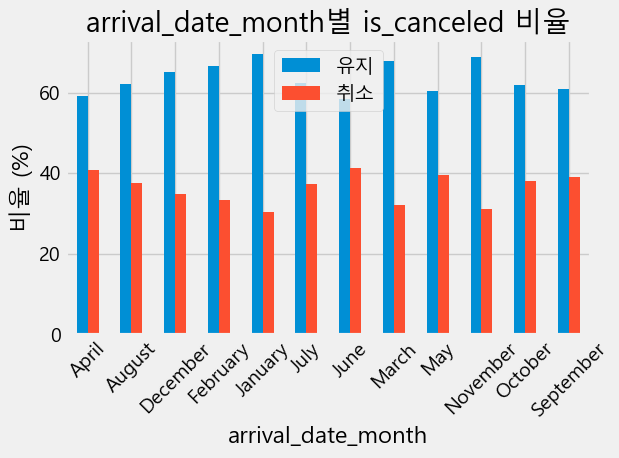

arrival_date_month별 취소/유지 비율:
is_canceled            0     1
arrival_date_month            
April               59.2  40.8
August              62.2  37.8
December            65.0  35.0
February            66.6  33.4
January             69.5  30.5
July                62.5  37.5
June                58.5  41.5
March               67.8  32.2
May                 60.3  39.7
November            68.8  31.2
October             62.0  38.0
September           60.8  39.2

📌 meal 분포:
meal
BB           0.773180
HB           0.121141
SC           0.089203
Undefined    0.009791
FB           0.006684
Name: proportion, dtype: float64


<Figure size 1200x600 with 0 Axes>

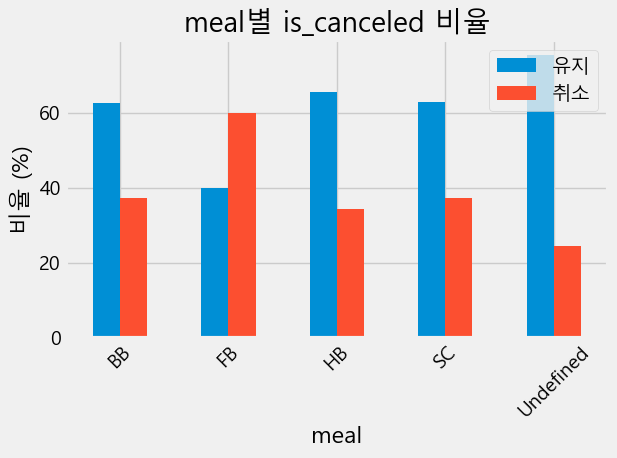

meal별 취소/유지 비율:
is_canceled     0     1
meal                   
BB           62.6  37.4
FB           40.1  59.9
HB           65.5  34.5
SC           62.8  37.2
Undefined    75.5  24.5

📌 country 분포:
country
PRT    0.408656
GBR    0.102008
FRA    0.087593
ESP    0.072059
DEU    0.061286
         ...   
MRT    0.000008
KIR    0.000008
SDN    0.000008
ATF    0.000008
SLE    0.000008
Name: proportion, Length: 177, dtype: float64


<Figure size 1200x600 with 0 Axes>

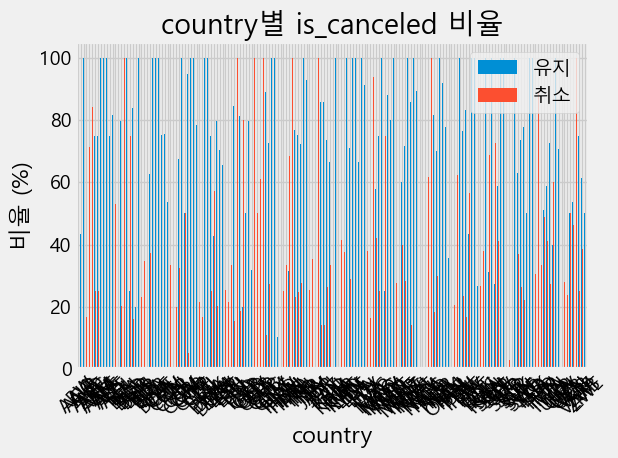

country별 취소/유지 비율:
is_canceled      0      1
country                  
ABW          100.0    0.0
AGO           43.4   56.6
AIA          100.0    0.0
ALB           83.3   16.7
AND           28.6   71.4
...            ...    ...
VGB            0.0  100.0
VNM           75.0   25.0
ZAF           61.3   38.8
ZMB           50.0   50.0
ZWE           50.0   50.0

[177 rows x 2 columns]

📌 market_segment 분포:
market_segment
Online TA        0.473046
Offline TA/TO    0.202856
Groups           0.165935
Direct           0.105587
Corporate        0.044350
Complementary    0.006223
Aviation         0.001985
Undefined        0.000017
Name: proportion, dtype: float64


<Figure size 1200x600 with 0 Axes>

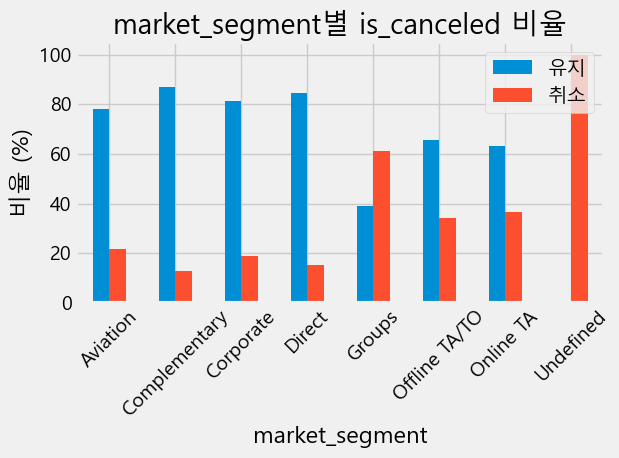

market_segment별 취소/유지 비율:
is_canceled        0      1
market_segment             
Aviation        78.1   21.9
Complementary   86.9   13.1
Corporate       81.3   18.7
Direct          84.7   15.3
Groups          38.9   61.1
Offline TA/TO   65.7   34.3
Online TA       63.3   36.7
Undefined        0.0  100.0

📌 distribution_channel 분포:
distribution_channel
TA/TO        0.819750
Direct       0.122665
Corporate    0.055926
GDS          0.001617
Undefined    0.000042
Name: proportion, dtype: float64


<Figure size 1200x600 with 0 Axes>

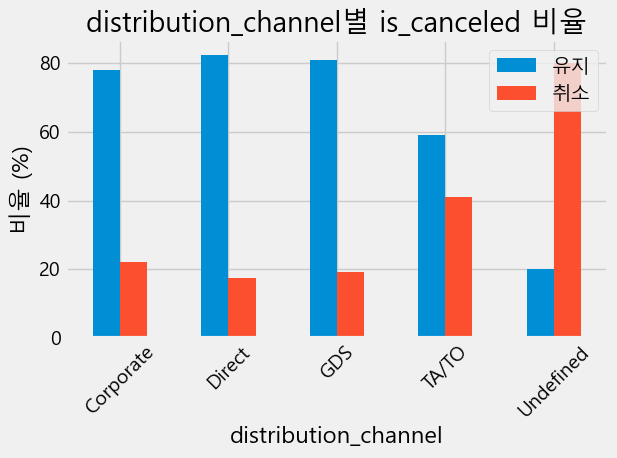

distribution_channel별 취소/유지 비율:
is_canceled              0     1
distribution_channel            
Corporate             77.9  22.1
Direct                82.5  17.5
GDS                   80.8  19.2
TA/TO                 59.0  41.0
Undefined             20.0  80.0

📌 reserved_room_type 분포:
reserved_room_type
A    0.720278
D    0.160826
E    0.054737
F    0.024265
G    0.017539
B    0.009364
C    0.007806
H    0.005034
P    0.000101
L    0.000050
Name: proportion, dtype: float64


<Figure size 1200x600 with 0 Axes>

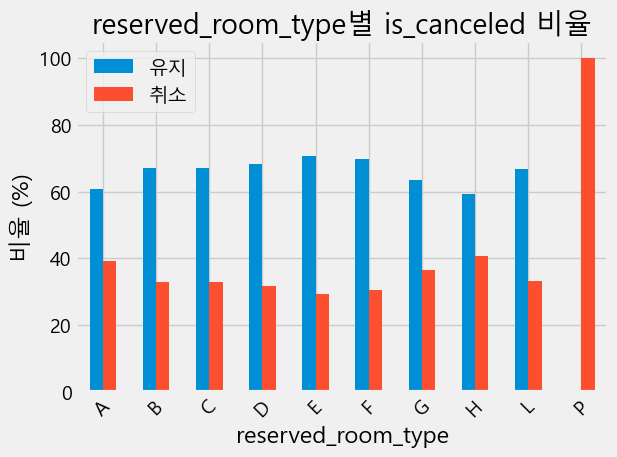

reserved_room_type별 취소/유지 비율:
is_canceled            0      1
reserved_room_type             
A                   60.9   39.1
B                   67.1   32.9
C                   67.0   33.0
D                   68.2   31.8
E                   70.7   29.3
F                   69.6   30.4
G                   63.6   36.4
H                   59.2   40.8
L                   66.7   33.3
P                    0.0  100.0

📌 assigned_room_type 분포:
assigned_room_type
A    0.620261
D    0.212095
E    0.065382
F    0.031418
G    0.021384
C    0.019893
B    0.018117
H    0.005964
I    0.003040
K    0.002337
P    0.000101
L    0.000008
Name: proportion, dtype: float64


<Figure size 1200x600 with 0 Axes>

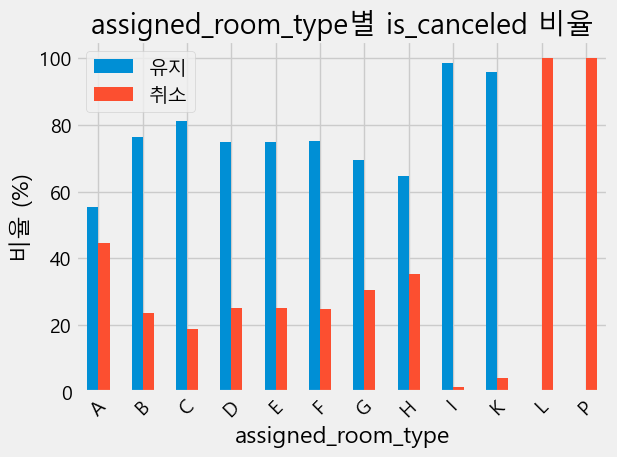

assigned_room_type별 취소/유지 비율:
is_canceled            0      1
assigned_room_type             
A                   55.5   44.5
B                   76.3   23.7
C                   81.2   18.8
D                   74.9   25.1
E                   74.8   25.2
F                   75.3   24.7
G                   69.4   30.6
H                   64.7   35.3
I                   98.6    1.4
K                   95.7    4.3
L                    0.0  100.0
P                    0.0  100.0

📌 deposit_type 분포:
deposit_type
No Deposit    0.876464
Non Refund    0.122179
Refundable    0.001357
Name: proportion, dtype: float64


<Figure size 1200x600 with 0 Axes>

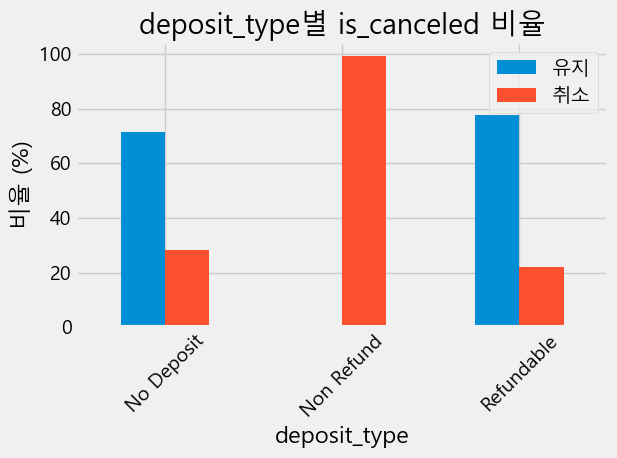

deposit_type별 취소/유지 비율:
is_canceled      0     1
deposit_type            
No Deposit    71.6  28.4
Non Refund     0.6  99.4
Refundable    77.8  22.2

📌 customer_type 분포:
customer_type
Transient          0.750591
Transient-Party    0.210436
Contract           0.034140
Group              0.004833
Name: proportion, dtype: float64


<Figure size 1200x600 with 0 Axes>

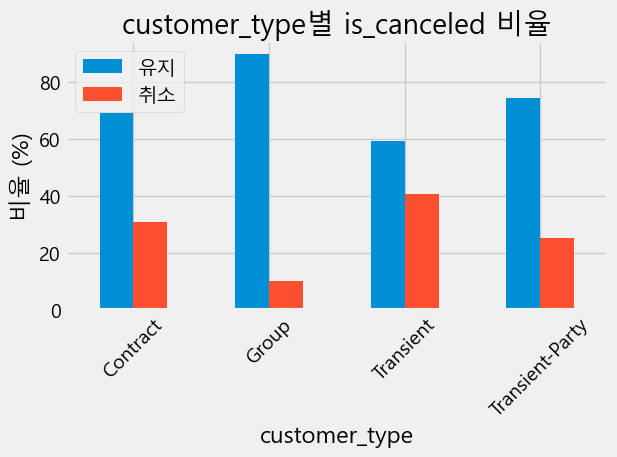

customer_type별 취소/유지 비율:
is_canceled         0     1
customer_type              
Contract         69.0  31.0
Group            89.8  10.2
Transient        59.3  40.7
Transient-Party  74.6  25.4

📌 reservation_status 분포:
reservation_status
Check-Out    0.629584
Canceled     0.360307
No-Show      0.010110
Name: proportion, dtype: float64


<Figure size 1200x600 with 0 Axes>

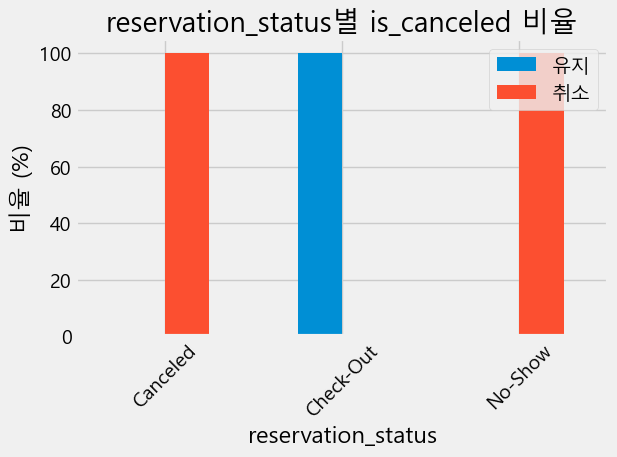

reservation_status별 취소/유지 비율:
is_canceled             0      1
reservation_status              
Canceled              0.0  100.0
Check-Out           100.0    0.0
No-Show               0.0  100.0

📌 reservation_status_date 분포:
reservation_status_date
2015-10-21    0.012237
2015-07-06    0.006743
2016-11-25    0.006617
2015-01-01    0.006391
2016-01-18    0.005235
                ...   
2015-02-26    0.000008
2015-03-18    0.000008
2015-03-12    0.000008
2015-03-11    0.000008
2015-06-14    0.000008
Name: proportion, Length: 926, dtype: float64


<Figure size 1200x600 with 0 Axes>

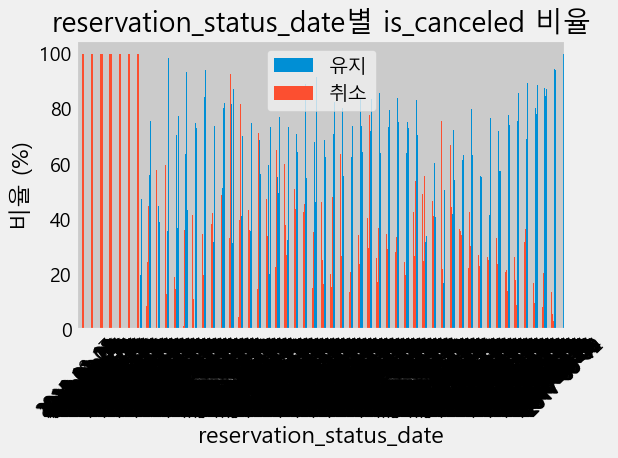

reservation_status_date별 취소/유지 비율:
is_canceled                  0      1
reservation_status_date              
2014-10-17                 0.0  100.0
2014-11-18                 0.0  100.0
2015-01-01                 0.0  100.0
2015-01-02                 0.0  100.0
2015-01-18                 0.0  100.0
...                        ...    ...
2017-09-08               100.0    0.0
2017-09-09               100.0    0.0
2017-09-10               100.0    0.0
2017-09-12               100.0    0.0
2017-09-14               100.0    0.0

[926 rows x 2 columns]


In [63]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


def eda_target_report(df, target_col):
    """
    df: 데이터프레임
    target_col: 타겟 변수명 (ex: 'is_canceled')
    """
    # 숫자형 / 범주형 변수 분리
    num_cols = df.select_dtypes(include=['int64', 'float64']).columns.drop(target_col)
    cat_cols = df.select_dtypes(include=['object', 'category', 'bool']).columns

    # 1. 타겟 분포
    print("🎯 Target 분포:")
    print(df[target_col].value_counts(normalize=True))
    sns.countplot(data=df, x=target_col)
    plt.title(f"Target Distribution: {target_col}")
    plt.show()

    # # 2. 숫자형 변수 vs 타겟
    # for col in num_cols:
    #     fig, axes = plt.subplots(1, 2, figsize=(12,4))
        
    #     sns.boxplot(data=df, x=target_col, y=col, ax=axes[0])
    #     axes[0].set_title(f"{col} vs {target_col} (Boxplot)")

    #     sns.histplot(data=df, x=col, hue=target_col, bins=50, kde=False, ax=axes[1])
    #     axes[1].set_title(f"{col} Distribution by {target_col}")

    #     plt.tight_layout()
    #     plt.show()

# 3. 범주형 변수 vs 타겟
    for col in cat_cols:
        print(f"\n📌 {col} 분포:")
        print(df[col].value_counts(normalize=True))
        
        # 교차표로 비율 계산
        cross_tab = pd.crosstab(df[col], df[target_col], normalize='index') * 100
        
        # 비율 막대그래프
        plt.figure(figsize=(12, 6))
        cross_tab.plot(kind='bar', stacked=False)
        plt.title(f'{col}별 {target_col} 비율')
        plt.xlabel(col)
        plt.ylabel('비율 (%)')
        plt.legend(['유지', '취소'])
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
        
        # 수치로도 확인
        print(f"{col}별 취소/유지 비율:")
        print(cross_tab.round(1))


# ======================================
# 실제 실행
eda_target_report(df, target_col='is_canceled')


# 3.데이터 분할 (중복 제거 후)
→ Train/Test
-> 피처. 타겟

In [64]:
# 중복 데이터 제거
df.drop_duplicates(inplace=True)
df.duplicated().sum(), df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 87396 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   hotel                           87396 non-null  object 
 1   is_canceled                     87396 non-null  int64  
 2   lead_time                       87396 non-null  int64  
 3   arrival_date_year               87396 non-null  int64  
 4   arrival_date_month              87396 non-null  object 
 5   arrival_date_week_number        87396 non-null  int64  
 6   arrival_date_day_of_month       87396 non-null  int64  
 7   stays_in_weekend_nights         87396 non-null  int64  
 8   stays_in_week_nights            87396 non-null  int64  
 9   adults                          87396 non-null  int64  
 10  children                        87392 non-null  float64
 11  babies                          87396 non-null  int64  
 12  meal                            8739

(np.int64(0), None)

In [65]:
from sklearn.model_selection import train_test_split
df_targets = df['is_canceled']
df_features = df.drop(['is_canceled'], axis=1)

tr_x, te_x, tr_y, te_y = train_test_split(df_features,df_targets, test_size=0.3 )


In [66]:
tr_x.shape, te_x.shape, tr_y.shape, te_y.shape

((61177, 31), (26219, 31), (61177,), (26219,))

# 4.Train 데이터로만 상세 분석:
- 결측치 처리 방법 결정
- 피처 엔지니어링
- 스케일링 파라미터 학습

In [67]:
# 필요 없는 컬럼 제거
drop_cols = ['arrival_date_day_of_month','arrival_date_year', 'arrival_date_month', 'arrival_date_week_number', 'country', 'reservation_status', 'reservation_status_date', 'hotel']
try:
    tr_x.drop(drop_cols, axis=1, inplace=True)
    te_x.drop(drop_cols, axis=1, inplace=True)
except:
    pass

tr_x.info()

<class 'pandas.core.frame.DataFrame'>
Index: 61177 entries, 114530 to 17567
Data columns (total 23 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   lead_time                       61177 non-null  int64  
 1   stays_in_weekend_nights         61177 non-null  int64  
 2   stays_in_week_nights            61177 non-null  int64  
 3   adults                          61177 non-null  int64  
 4   children                        61175 non-null  float64
 5   babies                          61177 non-null  int64  
 6   meal                            61177 non-null  object 
 7   market_segment                  61177 non-null  object 
 8   distribution_channel            61177 non-null  object 
 9   is_repeated_guest               61177 non-null  int64  
 10  previous_cancellations          61177 non-null  int64  
 11  previous_bookings_not_canceled  61177 non-null  int64  
 12  reserved_room_type              

In [68]:
# 결측치 제거 
# - 결측치 있는 컬럼명
null_cols = tr_x.columns[tr_x.isnull().sum() > 0]
null_cols

Index(['children', 'agent', 'company'], dtype='object')

In [69]:
#- 결측치 컬럼별로 확인
tr_x['company'].describe()

count    3651.000000
mean      182.363188
std       131.555541
min         6.000000
25%        46.000000
50%       169.000000
75%       263.000000
max       541.000000
Name: company, dtype: float64

In [70]:
fill_cols = ['children', 'company']
# 75%의 예약자들이 아이가 없다고 답했으므로 아이정보 없으면 아이가 없다고 가정하는 것이 합리적임. 따라서 최빈값으로 고

# 결측치 채우기
tr_x['children'].fillna(0, inplace=True)
te_x['children'].fillna(0, inplace=True)

# 회사를 통해 예약하지 않은 비율이 50%쯤이므로 회사를 통하지 않은 예약(결측치)은 0으로 처리
tr_x['company'].fillna(0, inplace=True)
te_x['company'].fillna(0, inplace=True)

tr_x['agent'].fillna(0, inplace=True)
te_x['agent'].fillna(0, inplace=True)

tr_x.isnull().sum().sum(), te_x.isnull().sum().sum()

(np.int64(0), np.int64(0))

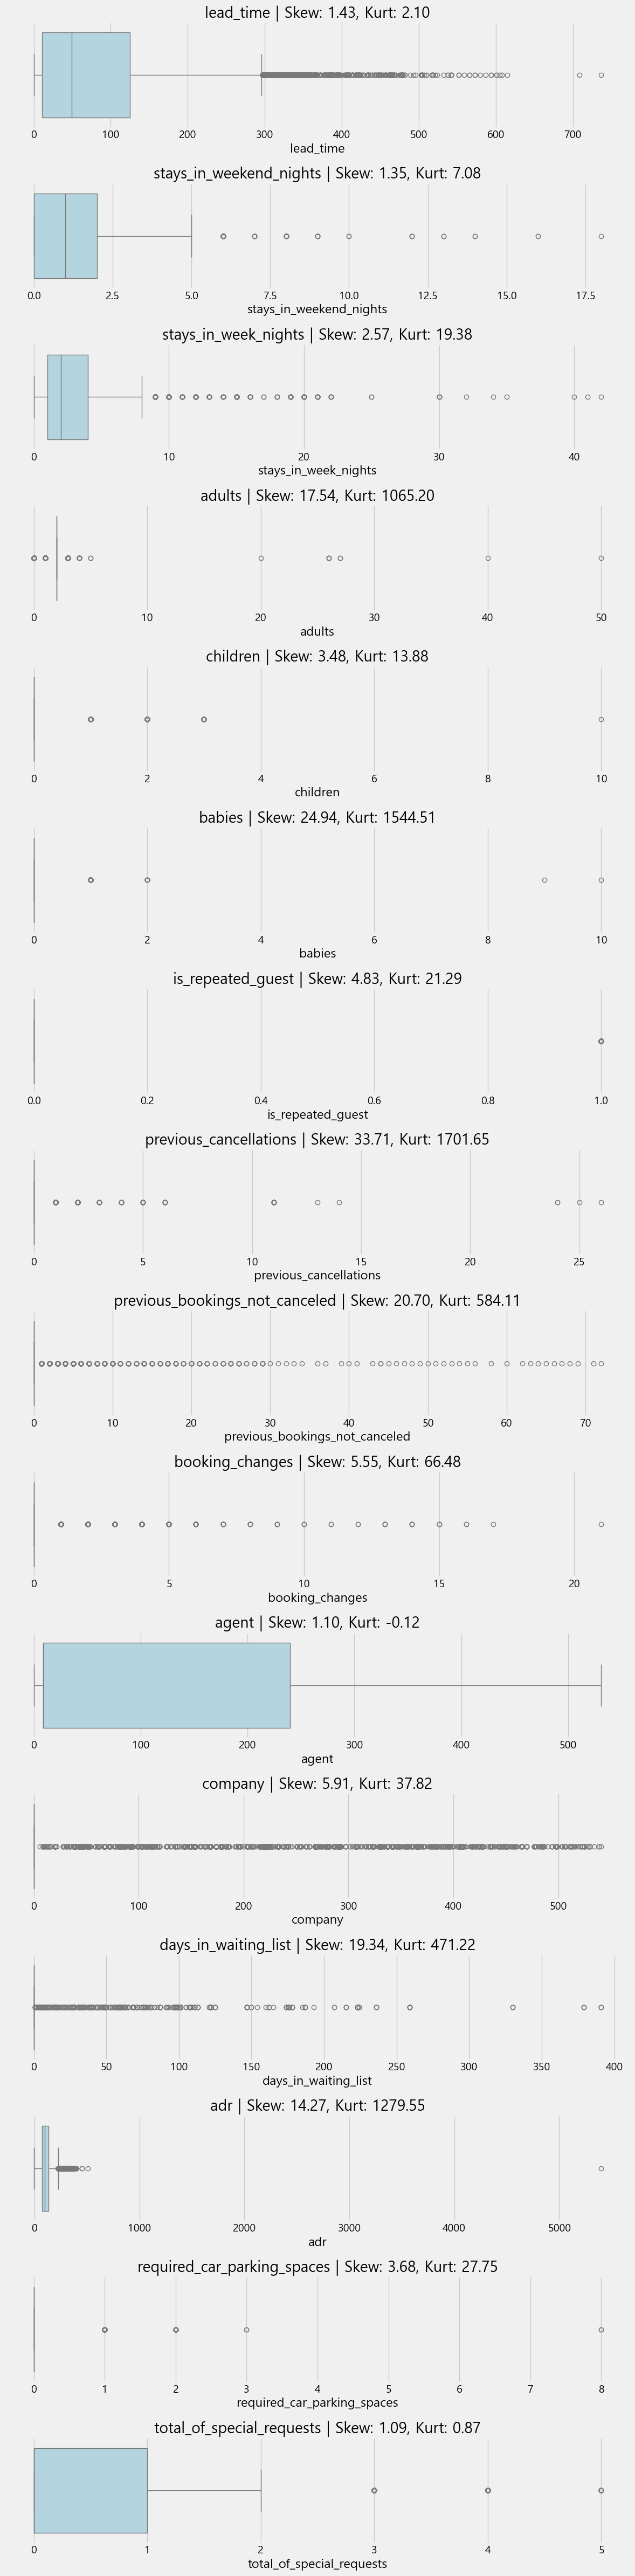

In [71]:
# 왜도 첨도 처리
## 왜도 첨도 여부 확인

import seaborn as sns
import matplotlib.pyplot as plt

# 숫자형 컬럼만 선택
num_cols = tr_x.select_dtypes(include=['int64','float64']).columns

plt.figure(figsize=(12, len(num_cols)*3))

for i, col in enumerate(num_cols, 1):
    skew = tr_x[col].skew()
    kurt = tr_x[col].kurt()
    
    plt.subplot(len(num_cols), 1, i)
    sns.boxplot(x=tr_x[col], color="lightblue")
    plt.title(f"{col} | Skew: {skew:.2f}, Kurt: {kurt:.2f}")

plt.tight_layout()
plt.show()



### 피처 생성

In [72]:
# te_x[company]의 값이 0보다 크면1 / 작으면 0
# company 값이 0보다 크면 1, 아니면 0  # .astype(int) : Boolean을 정수로 변환
te_x['has_company'] = (te_x['company'] > 0).astype(int)
tr_x['has_company'] = (tr_x['company'] > 0).astype(int)

# 확인
print("has_company 분포:")
print(tr_x['has_company'].value_counts()/len(tr_x['has_company']))

has_company 분포:
has_company
0    0.940321
1    0.059679
Name: count, dtype: float64


In [73]:
# te_x[agent]의 값이 0보다 크면1 / 작으면 0
# company 값이 0보다 크면 1, 아니면 0  # .astype(int) : Boolean을 정수로 변환
te_x['has_agent'] = (te_x['agent'] > 0).astype(int)
tr_x['has_agent'] = (tr_x['agent'] > 0).astype(int)

# 확인
print("has_agent 분포:")
print(tr_x['has_agent'].value_counts()/len(tr_x['has_agent']))

has_agent 분포:
has_agent
1    0.8615
0    0.1385
Name: count, dtype: float64


In [74]:
# meal이 FB이면 1, 아니면 0인 피처생성
import numpy as np

# np.where로 조건부 값 할당
tr_x['is_FB_meal'] = np.where(tr_x['meal'] == 'FB', 1, 0)
te_x['is_FB_meal'] = np.where(te_x['meal'] == 'FB', 1, 0)

# 확인
print("is_FB_meal 분포:")
print(tr_x['is_FB_meal'].value_counts()/len(tr_x['is_FB_meal']))

is_FB_meal 분포:
is_FB_meal
0    0.996061
1    0.003939
Name: count, dtype: float64


In [75]:
# te_x['has_agent ', 'agent', 'company', 'meal'] 컬럼 제거하기

# 필요 없는 컬럼 제거
drop_cols = ['has_agent ', 'agent', 'company', 'meal']
try:
    tr_x.drop(drop_cols, axis=1, inplace=True)
    te_x.drop(drop_cols, axis=1, inplace=True)
except:
    pass

tr_x.info()

<class 'pandas.core.frame.DataFrame'>
Index: 61177 entries, 114530 to 17567
Data columns (total 26 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   lead_time                       61177 non-null  int64  
 1   stays_in_weekend_nights         61177 non-null  int64  
 2   stays_in_week_nights            61177 non-null  int64  
 3   adults                          61177 non-null  int64  
 4   children                        61177 non-null  float64
 5   babies                          61177 non-null  int64  
 6   meal                            61177 non-null  object 
 7   market_segment                  61177 non-null  object 
 8   distribution_channel            61177 non-null  object 
 9   is_repeated_guest               61177 non-null  int64  
 10  previous_cancellations          61177 non-null  int64  
 11  previous_bookings_not_canceled  61177 non-null  int64  
 12  reserved_room_type              

In [76]:
tr_x['market_segment'].unique()

array(['Online TA', 'Direct', 'Offline TA/TO', 'Groups', 'Corporate',
       'Complementary', 'Aviation'], dtype=object)

In [77]:
# 리스크 레벨 매핑 딕셔너리
risk_mapping = {
    # High risk
    'Groups': 'High risk',
    'Online TA': 'High risk',
    
    # Medium risk  
    'Offline TA/TO': 'Medium risk',
    
    # Low risk
    'Direct': 'Low risk',
    'Corporate': 'Low risk',
    'Complementary': 'Low risk'
}

# 새 피처 생성
tr_x['market_risk_level'] = tr_x['market_segment'].map(risk_mapping)
te_x['market_risk_level'] = te_x['market_segment'].map(risk_mapping)

# 결과 확인
print("market_risk_level 분포:")
print(tr_x['market_risk_level'].value_counts()/len(tr_x['market_risk_level']))

# 매핑이 제대로 되었는지 확인
print("\n매핑 확인:")
mapping_check = tr_x.groupby('market_segment')['market_risk_level'].first()
print(mapping_check)

market_risk_level 분포:
market_risk_level
High risk      0.649362
Low risk       0.189499
Medium risk    0.158556
Name: count, dtype: float64

매핑 확인:
market_segment
Aviation                None
Complementary       Low risk
Corporate           Low risk
Direct              Low risk
Groups             High risk
Offline TA/TO    Medium risk
Online TA          High risk
Name: market_risk_level, dtype: object


In [78]:
# 두 컬럼 값이 다르면 1, 같으면 0
tr_x['room_type_changed'] = (tr_x['reserved_room_type'] != tr_x['assigned_room_type']).astype(int)
te_x['room_type_changed'] = (te_x['reserved_room_type'] != te_x['assigned_room_type']).astype(int)

# 결과 확인
print("room_type_changed 분포:")
print(tr_x['room_type_changed'].value_counts()/len(tr_x['room_type_changed']))
print(f"방 타입 변경된 비율: {tr_x['room_type_changed'].mean()*100:.1f}%")

room_type_changed 분포:
room_type_changed
0    0.849437
1    0.150563
Name: count, dtype: float64
방 타입 변경된 비율: 15.1%


In [79]:
# te_x[reserved_room_type, assigned_room_type ] 컬럼 제거하기

# 필요 없는 컬럼 제거
drop_cols = ['reserved_room_type', 'assigned_room_type']
try:
    tr_x.drop(drop_cols, axis=1, inplace=True)
    te_x.drop(drop_cols, axis=1, inplace=True)
except:
    pass

tr_x.info()

<class 'pandas.core.frame.DataFrame'>
Index: 61177 entries, 114530 to 17567
Data columns (total 26 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   lead_time                       61177 non-null  int64  
 1   stays_in_weekend_nights         61177 non-null  int64  
 2   stays_in_week_nights            61177 non-null  int64  
 3   adults                          61177 non-null  int64  
 4   children                        61177 non-null  float64
 5   babies                          61177 non-null  int64  
 6   meal                            61177 non-null  object 
 7   market_segment                  61177 non-null  object 
 8   distribution_channel            61177 non-null  object 
 9   is_repeated_guest               61177 non-null  int64  
 10  previous_cancellations          61177 non-null  int64  
 11  previous_bookings_not_canceled  61177 non-null  int64  
 12  booking_changes                 

왜도첨도 처리

In [80]:
## |왜도| >= 1, 첨도 >= 2 → 로그 변환 고려.
import numpy as np
import pandas as pd

def log_transform_skew_kurt(tr_x, te_x, threshold_skew=1, threshold_kurt=2):
    """
    threshold_skew: 왜도 기준 (기본 1)
    threshold_kurt: 첨도 기준 (기본 2)

    return: (변환된 DataFrame, 변환된 컬럼 리스트)
    """
    num_cols = tr_x.select_dtypes(include=['int64','float64']).columns
    transformed_cols = []

    for col in num_cols:
        skew = tr_x[col].skew()
        kurt = tr_x[col].kurt()

        if abs(skew) >= threshold_skew or kurt >= threshold_kurt:
            # 음수/0 값 방지 → log1p 사용
            tr_x[col + "_log"] = np.log1p(tr_x[col].clip(lower=0))
            te_x[col + "_log"] = np.log1p(tr_x[col].clip(lower=0))
            transformed_cols.append(col)

            print(f"🔄 {col} 변환됨 | Skew={skew:.2f}, Kurt={kurt:.2f}")

        else:
            print(f"⏭ {col} 그대로 둠 | Skew={skew:.2f}, Kurt={kurt:.2f}")

    return tr_x, te_x, transformed_cols


log_transform_skew_kurt(tr_x, te_x, threshold_skew=1, threshold_kurt=2)


🔄 lead_time 변환됨 | Skew=1.43, Kurt=2.10
🔄 stays_in_weekend_nights 변환됨 | Skew=1.35, Kurt=7.08
🔄 stays_in_week_nights 변환됨 | Skew=2.57, Kurt=19.38
🔄 adults 변환됨 | Skew=17.54, Kurt=1065.20
🔄 children 변환됨 | Skew=3.48, Kurt=13.88
🔄 babies 변환됨 | Skew=24.94, Kurt=1544.51
🔄 is_repeated_guest 변환됨 | Skew=4.83, Kurt=21.29
🔄 previous_cancellations 변환됨 | Skew=33.71, Kurt=1701.65
🔄 previous_bookings_not_canceled 변환됨 | Skew=20.70, Kurt=584.11
🔄 booking_changes 변환됨 | Skew=5.55, Kurt=66.48
🔄 agent 변환됨 | Skew=1.10, Kurt=-0.12
🔄 company 변환됨 | Skew=5.91, Kurt=37.82
🔄 days_in_waiting_list 변환됨 | Skew=19.34, Kurt=471.22
🔄 adr 변환됨 | Skew=14.27, Kurt=1279.55
🔄 required_car_parking_spaces 변환됨 | Skew=3.68, Kurt=27.75
🔄 total_of_special_requests 변환됨 | Skew=1.09, Kurt=0.87
🔄 has_company 변환됨 | Skew=3.72, Kurt=11.82
🔄 has_agent 변환됨 | Skew=-2.09, Kurt=2.38
🔄 is_FB_meal 변환됨 | Skew=15.84, Kurt=248.87
🔄 room_type_changed 변환됨 | Skew=1.95, Kurt=1.82


(        lead_time  stays_in_weekend_nights  stays_in_week_nights  adults  \
 114530         45                        1                     3       2   
 107334          2                        0                     2       3   
 2114            0                        0                     2       2   
 70030         332                        1                     3       2   
 19628           0                        1                     0       1   
 ...           ...                      ...                   ...     ...   
 39403         226                        2                     4       2   
 76812           2                        0                     1       1   
 95397           4                        0                     1       1   
 25838         196                        2                     3       2   
 17567          49                        3                     7       2   
 
         children  babies       meal market_segment distribution_channel  

인코딩
- 원핫인코딩 사용시에는 인코딩된 것을 외도첨도 처리하지 않음. 

In [81]:
import category_encoders as ce

encoder = ce.OneHotEncoder(use_cat_names=True)

enco_tr = pd.DataFrame()
enco_tr

""


In [82]:
# 한 줄로 확인
print(f"비수치형 컬럼 {tr_x.select_dtypes(exclude=[np.number]).columns}")

비수치형 컬럼 Index(['meal', 'market_segment', 'distribution_channel', 'deposit_type',
       'customer_type', 'market_risk_level'],
      dtype='object')


In [83]:
tr_x.select_dtypes(exclude=[np.number]).info()

<class 'pandas.core.frame.DataFrame'>
Index: 61177 entries, 114530 to 17567
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   meal                  61177 non-null  object
 1   market_segment        61177 non-null  object
 2   distribution_channel  61177 non-null  object
 3   deposit_type          61177 non-null  object
 4   customer_type         61177 non-null  object
 5   market_risk_level     61019 non-null  object
dtypes: object(6)
memory usage: 5.3+ MB


In [84]:
# dtype : 오브젝트->카테고리 for 메모리절약 위해

import pandas as pd
import numpy as np

print("=== Category 타입 변환 시작 ===")

# 1단계: 현재 메모리 사용량 측정
def get_memory_usage(df, name):
    """데이터프레임 메모리 사용량 계산"""
    memory_mb = df.memory_usage(deep=True).sum() / 1024 / 1024
    return memory_mb

# 변환 전 메모리 사용량
tr_memory_before = get_memory_usage(tr_x, "Train")
te_memory_before = get_memory_usage(te_x, "Test")
total_before = tr_memory_before + te_memory_before

print(f"📊 변환 전 메모리 사용량:")
print(f"   - 학습 데이터:  {tr_memory_before:.1f} MB")
print(f"   - 테스트 데이터: {te_memory_before:.1f} MB")
print(f"   - 총합:        {total_before:.1f} MB")

# 2단계: 범주형 컬럼 식별 및 분석
categorical_cols = tr_x.select_dtypes(include=['object']).columns.tolist()
print(f"\n🔍 범주형 컬럼 분석 ({len(categorical_cols)}개):")

conversion_candidates = []
for col in categorical_cols:
    unique_count = tr_x[col].nunique()
    total_count = len(tr_x)
    cardinality_ratio = unique_count / total_count
    
    # 메모리 절약 효과 예상
    if cardinality_ratio < 0.1:
        benefit = "높음 (70-90% 절약)"
        recommend = "✅ 강력 권장"
        conversion_candidates.append(col)
    elif cardinality_ratio < 0.3:
        benefit = "보통 (30-70% 절약)"
        recommend = "⚠️ 권장"
        conversion_candidates.append(col)
    elif cardinality_ratio < 0.7:
        benefit = "낮음 (10-30% 절약)"
        recommend = "△ 선택적"
    else:
        benefit = "매우 낮음 (< 10%)"
        recommend = "❌ 비권장"
    
    print(f"   {col:<25}: {unique_count:3d}개 ({cardinality_ratio:.1%}) → {recommend}")
    print(f"      예상 절약: {benefit}")

print(f"\n📋 변환 대상 컬럼: {len(conversion_candidates)}개")
for i, col in enumerate(conversion_candidates, 1):
    print(f"   {i}. {col}")

# 3단계: Category 타입 변환 실행
print(f"\n🔄 Category 타입 변환 진행...")

# 각 컬럼별 변환 및 메모리 절약 효과 측정
conversion_results = []

for col in conversion_candidates:
    # 변환 전 메모리
    before_memory = tr_x[col].memory_usage(deep=True)
    
    # 학습 데이터로 카테고리 정의 후 모든 데이터에 적용
    categories = tr_x[col].unique()
    
    # 모든 데이터셋에 동일한 카테고리 적용
    tr_x[col] = pd.Categorical(tr_x[col], categories=categories)
    te_x[col] = pd.Categorical(te_x[col], categories=categories)
    
    # 변환 후 메모리
    after_memory = tr_x[col].memory_usage(deep=True)
    savings_percent = (1 - after_memory / before_memory) * 100
    
    conversion_results.append({
        'column': col,
        'before_kb': before_memory / 1024,
        'after_kb': after_memory / 1024,
        'savings_percent': savings_percent
    })
    
    print(f"   ✅ {col:<25}: {savings_percent:5.1f}% 절약")

# 4단계: 전체 메모리 절약 효과 확인
tr_memory_after = get_memory_usage(tr_x, "Train")
te_memory_after = get_memory_usage(te_x, "Test")
total_after = tr_memory_after + te_memory_after

print(f"\n📊 변환 후 메모리 사용량:")
print(f"   - 학습 데이터:  {tr_memory_after:.1f} MB (이전: {tr_memory_before:.1f} MB)")
print(f"   - 테스트 데이터: {te_memory_after:.1f} MB (이전: {te_memory_before:.1f} MB)")
print(f"   - 총합:        {total_after:.1f} MB (이전: {total_before:.1f} MB)")

# 5단계: 총 절약 효과 계산
total_savings_mb = total_before - total_after
total_savings_percent = (total_savings_mb / total_before) * 100

print(f"\n🎉 총 메모리 절약 효과:")
print(f"   - 절약량:      {total_savings_mb:.1f} MB")
print(f"   - 절약률:      {total_savings_percent:.1f}%")

if total_savings_percent > 20:
    print(f"   ✅ 훌륭한 메모리 최적화!")
elif total_savings_percent > 10:
    print(f"   👍 좋은 메모리 절약!")
else:
    print(f"   ⚠️ 제한적인 절약 효과")

# 6단계: 변환 결과 상세 분석
print(f"\n📋 컬럼별 변환 결과 상세:")
print(f"{'컬럼명':<25} {'변환전(KB)':<12} {'변환후(KB)':<12} {'절약률(%)':<10}")
print("-" * 65)

for result in conversion_results:
    print(f"{result['column']:<25} {result['before_kb']:>10.1f} {result['after_kb']:>10.1f} {result['savings_percent']:>8.1f}%")

# 7단계: 데이터 타입 확인
print(f"\n🔍 변환 후 데이터 타입 분포:")
dtype_counts = tr_x.dtypes.value_counts()
for dtype, count in dtype_counts.items():
    print(f"   - {dtype}: {count}개 컬럼")

# 8단계: Category 타입 속성 확인
print(f"\n📊 Category 타입 속성 확인 (첫 번째 변환 컬럼):")
if conversion_candidates:
    sample_col = conversion_candidates[0]
    sample_cat = tr_x[sample_col]
    
    print(f"컬럼: {sample_col}")
    print(f"   - 데이터 타입: {sample_cat.dtype}")
    print(f"   - 카테고리 수: {len(sample_cat.cat.categories)}")
    print(f"   - 카테고리들: {sample_cat.cat.categories.tolist()[:10]}")  # 처음 10개만
    if len(sample_cat.cat.categories) > 10:
        print(f"     ... 및 {len(sample_cat.cat.categories)-10}개 더")
    
    print(f"   - 순서 여부: {sample_cat.cat.ordered}")
    print(f"   - 샘플 값: {sample_cat.head(5).tolist()}")
    print(f"   - 내부 코드: {sample_cat.cat.codes.head(5).tolist()}")

# 9단계: 검증 - 데이터 일관성 확인
print(f"\n✅ 데이터 일관성 검증:")
consistency_check = True

for col in conversion_candidates:
    # 모든 데이터셋의 카테고리가 동일한지 확인
    tr_cats = set(tr_x[col].cat.categories)
    te_cats = set(te_x[col].cat.categories)
    
    if tr_cats == te_cats:
        print(f"   ✅ {col}: 카테고리 일관성 OK")
    else:
        print(f"   ❌ {col}: 카테고리 불일치!")
        consistency_check = False

if consistency_check:
    print(f"   🎉 모든 컬럼의 카테고리가 일관성 있게 변환됨!")
else:
    print(f"   ⚠️ 일부 컬럼에서 카테고리 불일치 발생")

print(f"\n" + "="*60)
print(f"🎉 Category 타입 변환 완료!")
print(f"💾 총 {total_savings_mb:.1f} MB ({total_savings_percent:.1f}%) 메모리 절약!")
print(f"🚀 이제 더 효율적으로 인코딩을 진행할 수 있습니다!")

=== Category 타입 변환 시작 ===
📊 변환 전 메모리 사용량:
   - 학습 데이터:  40.9 MB
   - 테스트 데이터: 16.7 MB
   - 총합:        57.6 MB

🔍 범주형 컬럼 분석 (6개):
   meal                     :   5개 (0.0%) → ✅ 강력 권장
      예상 절약: 높음 (70-90% 절약)
   market_segment           :   7개 (0.0%) → ✅ 강력 권장
      예상 절약: 높음 (70-90% 절약)
   distribution_channel     :   5개 (0.0%) → ✅ 강력 권장
      예상 절약: 높음 (70-90% 절약)
   deposit_type             :   3개 (0.0%) → ✅ 강력 권장
      예상 절약: 높음 (70-90% 절약)
   customer_type            :   4개 (0.0%) → ✅ 강력 권장
      예상 절약: 높음 (70-90% 절약)
   market_risk_level        :   3개 (0.0%) → ✅ 강력 권장
      예상 절약: 높음 (70-90% 절약)

📋 변환 대상 컬럼: 6개
   1. meal
   2. market_segment
   3. distribution_channel
   4. deposit_type
   5. customer_type
   6. market_risk_level

🔄 Category 타입 변환 진행...
   ✅ meal                     :  53.5% 절약
   ✅ market_segment           :  56.7% 절약
   ✅ distribution_channel     :  55.1% 절약
   ✅ deposit_type             :  57.1% 절약
   ✅ customer_type            :  57.0% 절약


ValueError: Categorical categories cannot be null

In [86]:
print("=== 인코딩 준비 상태 ===")

# Category 타입 컬럼 확인
category_cols = tr_x.select_dtypes(include=['category']).columns.tolist()
object_cols = tr_x.select_dtypes(include=['object']).columns.tolist()

print(f"Category 타입: {len(category_cols)}개")
print(f"Object 타입:   {len(object_cols)}개")

print(f"\n✅ Category 변환 완료! 이제 원핫인코딩을 더 효율적으로 실행할 수 있습니다!")

=== 인코딩 준비 상태 ===
Category 타입: 5개
Object 타입:   1개

✅ Category 변환 완료! 이제 원핫인코딩을 더 효율적으로 실행할 수 있습니다!


In [87]:
tr_x.select_dtypes(include=['object']).info()

<class 'pandas.core.frame.DataFrame'>
Index: 61177 entries, 114530 to 17567
Data columns (total 1 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   market_risk_level  61019 non-null  object
dtypes: object(1)
memory usage: 2.9+ MB


In [88]:
import category_encoders as ce
import pandas as pd

# 1단계: 범주형 컬럼 식별
print("=== 범주형 컬럼 식별 ===")
categorical_cols = tr_x.select_dtypes(include=['object', 'category']).columns.tolist()
print(f"범주형 컬럼 ({len(categorical_cols)}개):")
for i, col in enumerate(categorical_cols, 1):
    unique_count = tr_x[col].nunique()
    print(f"{i:2d}. {col:<25} : {unique_count:3d}개 카테고리")

print(f"\n총 범주형 컬럼: {len(categorical_cols)}개")
print("="*60)

# 2단계: OneHot Encoder 설정
encoder = ce.OneHotEncoder(
    cols=categorical_cols,        # 인코딩할 컬럼들
    use_cat_names=True,          # 카테고리 이름 사용
    drop_invariant=False          # 변화없는 컬럼 제거
)

# 3단계: 학습 데이터로 fit & transform
print("\n=== 원핫인코딩 진행 ===")
print("🔄 학습 데이터 인코딩 중...")
tr_x_encoded = encoder.fit_transform(tr_x)

print("🔄 테스트 데이터 인코딩 중...")
te_x_encoded = encoder.transform(te_x)

# 4단계: 결과 확인
print("\n=== 인코딩 결과 ===")
print(f"📊 원본 데이터 크기:")
print(f"   - 학습: {tr_x.shape}")
print(f"   - 테스트: {te_x.shape}")

print(f"\n📊 인코딩 후 데이터 크기:")
print(f"   - 학습: {tr_x_encoded.shape}")
print(f"   - 테스트: {te_x_encoded.shape}")

print(f"\n📈 컬럼 수 변화:")
print(f"   - 원본: {tr_x.shape[1]}개 → 인코딩 후: {tr_x_encoded.shape[1]}개")
print(f"   - 증가: +{tr_x_encoded.shape[1] - tr_x.shape[1]}개 컬럼")

# 5단계: 새로 생성된 컬럼들 확인
print("\n=== 새로 생성된 컬럼들 (처음 20개) ===")
original_cols = set(tr_x.select_dtypes(exclude=['object']).columns)
new_cols = [col for col in tr_x_encoded.columns if col not in original_cols]

print(f"새로 생성된 원핫인코딩 컬럼: {len(new_cols)}개")
for i, col in enumerate(new_cols[:20], 1):
    print(f"{i:2d}. {col}")

if len(new_cols) > 20:
    print(f"... 및 {len(new_cols)-20}개 더")

# 6단계: 데이터 타입 확인
print(f"\n=== 데이터 타입 확인 ===")
print("인코딩 후 데이터 타입:")
dtype_counts = tr_x_encoded.dtypes.value_counts()
for dtype, count in dtype_counts.items():
    print(f"   - {dtype}: {count}개 컬럼")

# 7단계: 메모리 사용량 확인
print(f"\n=== 메모리 사용량 ===")
tr_memory_mb = tr_x_encoded.memory_usage(deep=True).sum() / 1024 / 1024
te_memory_mb = te_x_encoded.memory_usage(deep=True).sum() / 1024 / 1024

print(f"   - 학습 데이터: {tr_memory_mb:.1f} MB")
print(f"   - 테스트 데이터: {te_memory_mb:.1f} MB")
print(f"   - 총 메모리: {tr_memory_mb + te_memory_mb:.1f} MB")

# 8단계: 샘플 데이터 확인
print(f"\n=== 샘플 데이터 미리보기 ===")
print("원핫인코딩된 데이터 (처음 5행, 처음 10컬럼):")
print(tr_x_encoded.iloc[:5, :10])

print(f"\n✅ 모든 범주형 데이터 원핫인코딩 완료!")
print(f"📝 인코딩된 데이터는 tr_x_encoded, te_x_encoded에 저장됨")

# 9단계: 원본 데이터와 비교 (선택사항)
print(f"\n=== 원본 vs 인코딩 비교 (첫 번째 범주형 컬럼) ===")
if categorical_cols:
    sample_col = categorical_cols[0]
    print(f"원본 '{sample_col}' 컬럼:")
    print(tr_x[sample_col].head())
    
    # 해당 컬럼의 원핫인코딩 결과
    onehot_cols = [col for col in tr_x_encoded.columns if col.startswith(f"{sample_col}_")]
    if onehot_cols:
        print(f"\n원핫인코딩된 '{sample_col}' 관련 컬럼들:")
        print(tr_x_encoded[onehot_cols].head())

print("\n" + "="*60)
print("🎉 원핫인코딩 작업 완료! 이제 모델링을 진행할 수 있습니다.")

=== 범주형 컬럼 식별 ===
범주형 컬럼 (6개):
 1. meal                      :   5개 카테고리
 2. market_segment            :   7개 카테고리
 3. distribution_channel      :   5개 카테고리
 4. deposit_type              :   3개 카테고리
 5. customer_type             :   4개 카테고리
 6. market_risk_level         :   3개 카테고리

총 범주형 컬럼: 6개

=== 원핫인코딩 진행 ===
🔄 학습 데이터 인코딩 중...
🔄 테스트 데이터 인코딩 중...

=== 인코딩 결과 ===
📊 원본 데이터 크기:
   - 학습: (61177, 46)
   - 테스트: (26219, 46)

📊 인코딩 후 데이터 크기:
   - 학습: (61177, 68)
   - 테스트: (26219, 68)

📈 컬럼 수 변화:
   - 원본: 46개 → 인코딩 후: 68개
   - 증가: +22개 컬럼

=== 새로 생성된 컬럼들 (처음 20개) ===
새로 생성된 원핫인코딩 컬럼: 28개
 1. meal_BB
 2. meal_SC
 3. meal_HB
 4. meal_Undefined
 5. meal_FB
 6. market_segment_Online TA
 7. market_segment_Direct
 8. market_segment_Offline TA/TO
 9. market_segment_Groups
10. market_segment_Corporate
11. market_segment_Complementary
12. market_segment_Aviation
13. distribution_channel_TA/TO
14. distribution_channel_Direct
15. distribution_channel_Corporate
16. distribution_channel_GDS
17. distribut

스케일링
- 원핫인코딩하지 않은 컬럼들만. 

In [89]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

print("=== StandardScaler 스케일링 시작 ===")

# 1단계: 스케일러 생성
scaler = StandardScaler()

# 2단계: 스케일링 전 데이터 상태 확인
print("📊 스케일링 전 데이터 통계:")
print(f"   - 평균: {tr_x_encoded.mean().mean():.4f}")
print(f"   - 표준편차: {tr_x_encoded.std().mean():.4f}")
print(f"   - 최솟값: {tr_x_encoded.min().min():.2f}")
print(f"   - 최댓값: {tr_x_encoded.max().max():.2f}")

=== StandardScaler 스케일링 시작 ===
📊 스케일링 전 데이터 통계:
   - 평균: 4.5374
   - 표준편차: 5.0272
   - 최솟값: -6.38
   - 최댓값: 5400.00


In [91]:
print("=== 로그 변환 후 스케일링 필요성 분석 ===")

# 1단계: 로그 변환된 컬럼들 확인
print("🔍 로그 변환된 컬럼들 식별...")

# 로그 변환 컬럼 찾기 (컬럼명에 '_log' 포함)
log_transformed_cols = [col for col in tr_x_encoded.columns if '_log' in col]
original_numeric_cols = [col for col in tr_x_encoded.columns 
                        if col not in log_transformed_cols and 
                        tr_x_encoded[col].dtype in ['int64', 'float64'] and
                        not (len(tr_x_encoded[col].unique()) <= 2 and 
                             set(tr_x_encoded[col].unique()).issubset({0, 1}))]

print(f"📊 수치형 데이터 분류:")
print(f"   - 로그 변환된 컬럼: {len(log_transformed_cols)}개")
print(f"   - 원본 수치형 컬럼:  {len(original_numeric_cols)}개")

# 로그 변환 컬럼 샘플
if log_transformed_cols:
    print(f"\n🔍 로그 변환 컬럼 샘플:")
    for col in log_transformed_cols[:5]:
        print(f"   - {col}")

# 2단계: 로그 변환 후 스케일 분석
if log_transformed_cols:
    print(f"\n📈 로그 변환된 컬럼들의 스케일 분석:")
    
    log_scales = []
    for col in log_transformed_cols:
        min_val = tr_x_encoded[col].min()
        max_val = tr_x_encoded[col].max()
        mean_val = tr_x_encoded[col].mean()
        std_val = tr_x_encoded[col].std()
        range_val = max_val - min_val
        
        log_scales.append({
            'column': col,
            'min': min_val,
            'max': max_val,
            'range': range_val,
            'mean': mean_val,
            'std': std_val
        })
        
        print(f"   {col:<30}: [{min_val:8.2f} ~ {max_val:8.2f}] 평균: {mean_val:6.2f} 표준편차: {std_val:6.2f}")
    
    # 스케일 차이 분석
    ranges = [item['range'] for item in log_scales if item['range'] > 0]
    if ranges:
        max_range = max(ranges)
        min_range = min(ranges)
        scale_ratio = max_range / min_range if min_range > 0 else float('inf')
        
        print(f"\n📊 로그 변환 후 스케일 차이:")
        print(f"   - 최대 범위: {max_range:.2f}")
        print(f"   - 최소 범위: {min_range:.2f}")
        print(f"   - 스케일 비율: {scale_ratio:.1f}배")
        
        if scale_ratio > 10:
            recommendation = "🔄 스케일링 여전히 권장"
            reason = "로그 변환 후에도 스케일 차이가 큼"
        elif scale_ratio > 3:
            recommendation = "⚠️ 스케일링 고려"
            reason = "중간 정도의 스케일 차이"
        else:
            recommendation = "✅ 스케일링 불필요할 수 있음"
            reason = "로그 변환으로 스케일이 비슷해짐"
            
        print(f"   → {recommendation}")
        print(f"   → 이유: {reason}")

# 3단계: 원본 수치형 컬럼들도 확인
if original_numeric_cols:
    print(f"\n📈 원본 수치형 컬럼들의 스케일:")
    
    for col in original_numeric_cols[:5]:
        min_val = tr_x_encoded[col].min()
        max_val = tr_x_encoded[col].max()
        mean_val = tr_x_encoded[col].mean()
        std_val = tr_x_encoded[col].std()
        range_val = max_val - min_val
        
        print(f"   {col:<30}: [{min_val:8.2f} ~ {max_val:8.2f}] 평균: {mean_val:6.2f} 표준편차: {std_val:6.2f}")

=== 로그 변환 후 스케일링 필요성 분석 ===
🔍 로그 변환된 컬럼들 식별...
📊 수치형 데이터 분류:
   - 로그 변환된 컬럼: 20개
   - 원본 수치형 컬럼:  15개

🔍 로그 변환 컬럼 샘플:
   - lead_time_log
   - stays_in_weekend_nights_log
   - stays_in_week_nights_log
   - adults_log
   - children_log

📈 로그 변환된 컬럼들의 스케일 분석:
   lead_time_log                 : [    0.00 ~     6.60] 평균:   3.53 표준편차:   1.63
   stays_in_weekend_nights_log   : [    0.00 ~     2.94] 평균:   0.57 표준편차:   0.51
   stays_in_week_nights_log      : [    0.00 ~     3.76] 평균:   1.15 표준편차:   0.53
   adults_log                    : [    0.00 ~     3.93] 평균:   1.04 표준편차:   0.20
   children_log                  : [    0.00 ~     2.40] 평균:   0.08 표준편차:   0.26
   babies_log                    : [    0.00 ~     2.40] 평균:   0.01 표준편차:   0.07
   is_repeated_guest_log         : [    0.00 ~     0.69] 평균:   0.03 표준편차:   0.13
   previous_cancellations_log    : [    0.00 ~     3.30] 평균:   0.02 표준편차:   0.13
   previous_bookings_not_canceled_log: [    0.00 ~     4.29] 평균:   0.05 표준편차:   0.30
   booking

In [96]:
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
import pandas as pd

print("=== LightGBM + 선별적 StandardScaler ===")

# 1단계: 원핫인코딩 컬럼과 연속형 컬럼 분리
print("🔍 컬럼 타입 분석 중...")

onehot_cols = []
continuous_cols = []

for col in tr_x_encoded.columns:
    unique_vals = sorted(tr_x_encoded[col].unique())
    
    # 0과 1만 가지거나, 0만 가지거나, 1만 가지는 컬럼 = 원핫인코딩
    if (len(unique_vals) == 2 and set(unique_vals) == {0, 1}) or \
       (len(unique_vals) == 1 and unique_vals[0] in [0, 1]):
        onehot_cols.append(col)
    else:
        continuous_cols.append(col)

print(f"📊 컬럼 분류 결과:")
print(f"   - 원핫인코딩 컬럼: {len(onehot_cols)}개 (스케일링 제외)")
print(f"   - 연속형 컬럼:     {len(continuous_cols)}개 (스케일링 적용)")

# 연속형 컬럼들의 스케일 확인
if continuous_cols:
    print(f"\n📈 연속형 컬럼 스케일 분석 (처음 5개):")
    for col in continuous_cols[:5]:
        min_val = tr_x_encoded[col].min()
        max_val = tr_x_encoded[col].max()
        mean_val = tr_x_encoded[col].mean()
        range_val = max_val - min_val
        print(f"   {col:<25}: [{min_val:8.2f} ~ {max_val:8.2f}] 범위: {range_val:10.2f}")

# 2단계: 연속형 컬럼만 StandardScaler 적용
if continuous_cols:
    print(f"\n🔄 연속형 컬럼만 StandardScaler 적용 중...")
    
    # 스케일러 생성
    scaler = StandardScaler()
    
    # 연속형 컬럼만 추출
    tr_x_continuous = tr_x_encoded[continuous_cols]
    te_x_continuous = te_x_encoded[continuous_cols]
    
    # 스케일링 적용 (학습 데이터로 fit, 테스트 데이터는 transform만)
    tr_x_continuous_scaled = scaler.fit_transform(tr_x_continuous)
    te_x_continuous_scaled = scaler.transform(te_x_continuous)
    
    print(f"✅ 연속형 컬럼 스케일링 완료!")
    print(f"   - 스케일링 후 평균: {tr_x_continuous_scaled.mean():.6f}")
    print(f"   - 스케일링 후 표준편차: {tr_x_continuous_scaled.std():.6f}")
    
    # 원핫인코딩 컬럼은 그대로 유지
    print(f"🔄 원핫인코딩 컬럼 유지 중...")
    tr_x_onehot = tr_x_encoded[onehot_cols].values
    te_x_onehot = te_x_encoded[onehot_cols].values
    
    # 스케일링된 연속형 + 원핫인코딩 결합
    print(f"🔄 데이터 결합 중...")
    tr_x_final = np.hstack([tr_x_continuous_scaled, tr_x_onehot])
    te_x_final = np.hstack([te_x_continuous_scaled, te_x_onehot])
    
    print(f"✅ 최종 데이터 생성 완료!")
    print(f"   - 스케일링된 연속형: {tr_x_continuous_scaled.shape[1]}개 컬럼")
    print(f"   - 유지된 원핫인코딩: {tr_x_onehot.shape[1]}개 컬럼")
    print(f"   - 최종 데이터 크기: {tr_x_final.shape}")
    
else:
    # 모든 컬럼이 원핫인코딩인 경우
    print(f"📝 모든 컬럼이 원핫인코딩 → 스케일링 불필요")
    tr_x_final = tr_x_encoded.values
    te_x_final = te_x_encoded.values

print(f"\n" + "="*60)

# 3단계: LightGBM 모델 학습 및 비교
print("=== LightGBM 성능 비교 ===")

# 3-1: 스케일링 없는 LightGBM
print(f"🔄 스케일링 없는 LightGBM 학습 중...")
lgb_no_scale = lgb.LGBMClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42,
    verbose=-1  # 출력 억제
)

lgb_no_scale.fit(tr_x_encoded, tr_y)
y_pred_no_scale = lgb_no_scale.predict(te_x_encoded)
accuracy_no_scale = accuracy_score(te_y, y_pred_no_scale)

print(f"✅ No Scaler 정확도: {accuracy_no_scale:.4f}")

# 3-2: 선별적 스케일링 LightGBM
print(f"🔄 선별적 스케일링 LightGBM 학습 중...")
lgb_scaled = lgb.LGBMClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42,
    verbose=-1  # 출력 억제
)

lgb_scaled.fit(tr_x_final, tr_y)
y_pred_scaled = lgb_scaled.predict(te_x_final)
accuracy_scaled = accuracy_score(te_y, y_pred_scaled)

print(f"✅ 선별적 Scaler 정확도: {accuracy_scaled:.4f}")

# 3-3: 성능 비교
print(f"\n📊 LightGBM 성능 비교:")
print(f"   - No Scaler:        {accuracy_no_scale:.4f}")
print(f"   - 선별적 Scaler:    {accuracy_scaled:.4f}")

improvement = accuracy_scaled - accuracy_no_scale
if improvement > 0.001:
    print(f"   🎉 성능 향상: +{improvement:.4f} ({improvement*100:.1f}%p)")
elif improvement < -0.001:
    print(f"   📉 성능 하락: {improvement:.4f} ({improvement*100:.1f}%p)")
else:
    print(f"   📊 성능 거의 동일")

# 4단계: 상세 분류 리포트 (더 좋은 모델로)
best_model = lgb_scaled if accuracy_scaled >= accuracy_no_scale else lgb_no_scale
best_predictions = y_pred_scaled if accuracy_scaled >= accuracy_no_scale else y_pred_no_scale
best_method = "선별적 스케일링" if accuracy_scaled >= accuracy_no_scale else "스케일링 없음"

print(f"\n📋 최고 성능 모델 ({best_method}) 상세 리포트:")
print(classification_report(te_y, best_predictions))

# 5단계: 특성 중요도 (LightGBM)
print(f"\n🎯 특성 중요도 (상위 10개):")
feature_names = (continuous_cols + onehot_cols) if continuous_cols else list(tr_x_encoded.columns)
feature_importance = best_model.feature_importances_

# 중요도 순으로 정렬
importance_pairs = list(zip(feature_names, feature_importance))
importance_pairs.sort(key=lambda x: x[1], reverse=True)

for i, (feature, importance) in enumerate(importance_pairs[:10], 1):
    print(f"   {i:2d}. {feature:<30}: {importance:.4f}")

# 6단계: 예측 확률 분포
print(f"\n📈 예측 확률 분포:")
y_pred_proba = best_model.predict_proba(te_x_final if accuracy_scaled >= accuracy_no_scale else te_x_encoded)[:, 1]

print(f"   - 평균 취소 확률: {y_pred_proba.mean():.4f}")
print(f"   - 확률 표준편차:   {y_pred_proba.std():.4f}")
print(f"   - 최소 확률:       {y_pred_proba.min():.4f}")
print(f"   - 최대 확률:       {y_pred_proba.max():.4f}")

# 예측 결과 분포
print(f"\n📊 예측 결과 분포:")
unique, counts = np.unique(best_predictions, return_counts=True)
for pred, count in zip(unique, counts):
    percentage = count / len(best_predictions) * 100
    status = "취소" if pred == 1 else "유지"
    print(f"   - {status}: {count:,}건 ({percentage:.1f}%)")

print(f"\n" + "="*60)
print(f"🎉 LightGBM + 선별적 StandardScaler 완료!")
print(f"✅ 최고 성능: {max(accuracy_no_scale, accuracy_scaled):.4f} ({best_method})")
print(f"📝 LightGBM은 트리 기반 모델이라 스케일링 효과가 제한적일 수 있음")

=== LightGBM + 선별적 StandardScaler ===
🔍 컬럼 타입 분석 중...
📊 컬럼 분류 결과:
   - 원핫인코딩 컬럼: 33개 (스케일링 제외)
   - 연속형 컬럼:     35개 (스케일링 적용)

📈 연속형 컬럼 스케일 분석 (처음 5개):
   lead_time                : [    0.00 ~   737.00] 범위:     737.00
   stays_in_weekend_nights  : [    0.00 ~    18.00] 범위:      18.00
   stays_in_week_nights     : [    0.00 ~    42.00] 범위:      42.00
   adults                   : [    0.00 ~    50.00] 범위:      50.00
   children                 : [    0.00 ~    10.00] 범위:      10.00

🔄 연속형 컬럼만 StandardScaler 적용 중...
✅ 연속형 컬럼 스케일링 완료!
   - 스케일링 후 평균: 0.000000
   - 스케일링 후 표준편차: 1.000000
🔄 원핫인코딩 컬럼 유지 중...
🔄 데이터 결합 중...
✅ 최종 데이터 생성 완료!
   - 스케일링된 연속형: 35개 컬럼
   - 유지된 원핫인코딩: 33개 컬럼
   - 최종 데이터 크기: (61177, 68)

=== LightGBM 성능 비교 ===
🔄 스케일링 없는 LightGBM 학습 중...
✅ No Scaler 정확도: 0.8231
🔄 선별적 스케일링 LightGBM 학습 중...
✅ 선별적 Scaler 정확도: 0.8164

📊 LightGBM 성능 비교:
   - No Scaler:        0.8231
   - 선별적 Scaler:    0.8164
   📉 성능 하락: -0.0067 (-0.7%p)

📋 최고 성능 모델 (스케일링 없음) 상세 리포트:
              precision

# 5.모델 학습 → Train 데이터
- 라이트 비지엠

# 6.하이퍼파라미터 튜닝 → Validation 데이터로 검증
- Cv - train데이터 내에서만 사용

# 7.최종 평가 → Test 데이터 (한 번만!)

In [ ]:
ori_train = pd.read_csv(args.train_csv)
ori_test = pd.read_csv(args.test_csv)

ori_train.shape, ori_test.shape  # 테스트에는 타겟이 없어서 컬럼이 하나 작음

AttributeError: 'EasyDict' object has no attribute 'test_csv'